In [10]:
import IPython.display


In [244]:
import astropy.io.fits
import matplotlib.pyplot as plt

import numpy
import numpy as np
import scipy
import scipy.stats

In [184]:


fits = astropy.io.fits.open("../../data/hsc-image-small.fits")
image = fits[0].data
detections = fits[2].data


In [185]:
print image.shape

(267, 263)


In [186]:
print image


[[ 0.09158576  0.03363228  0.08952592 ..., -0.04019628 -0.0334042
   0.04539815]
 [ 0.09178635  0.03560242  0.0859936  ...,  0.07195406  0.04319087
   0.01988844]
 [ 0.0514395   0.1001677   0.03162279 ...,  0.00616413  0.02562633
   0.01488036]
 ..., 
 [-0.09680363 -0.00543881 -0.02453763 ...,  0.00383089  0.00038972
  -0.06011525]
 [-0.01396252  0.04107647  0.01353033 ...,  0.03934022 -0.03763667
  -0.02042486]
 [ 0.0427515   0.00123117  0.02867347 ...,  0.02168421 -0.02147566
   0.03712478]]


In [187]:
exampleMask = detections==1
print exampleMask

[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]


In [188]:
def GetCoordinateArrays(Image):
    xcoords = numpy.arange(Image.shape[1])
    ycoords = numpy.arange(Image.shape[0])
    x2d, y2d = numpy.meshgrid( xcoords, ycoords )
    return x2d, y2d

In [189]:
CoordsX, CoordsY = GetCoordinateArrays(image)
print CoordsX, CoordsY

[[  0   1   2 ..., 260 261 262]
 [  0   1   2 ..., 260 261 262]
 [  0   1   2 ..., 260 261 262]
 ..., 
 [  0   1   2 ..., 260 261 262]
 [  0   1   2 ..., 260 261 262]
 [  0   1   2 ..., 260 261 262]] [[  0   0   0 ...,   0   0   0]
 [  1   1   1 ...,   1   1   1]
 [  2   2   2 ...,   2   2   2]
 ..., 
 [264 264 264 ..., 264 264 264]
 [265 265 265 ..., 265 265 265]
 [266 266 266 ..., 266 266 266]]


In [190]:
def ZeroMoment(Image, Mask):
    Moment = numpy.sum(Image[Mask])
    return Moment
    

In [191]:
ZeroMomentValue = ZeroMoment(image, detections==0 )
print ZeroMomentValue

216.471


In [192]:
def FirstMoments(Image, Mask):
    
    ZeroMomentValue = ZeroMoment(Image, Mask)
    #print 'ZeroMomentValue', ZeroMomentValue
    ImageCoordinateArrayX, ImageCoordinateArrayY = GetCoordinateArrays(Image)
        
    #print ' ImageCoordinateArrayX', ImageCoordinateArrayX
    #print 'ImageCoordinateArrayX.shape', ImageCoordinateArrayX.shape
    #print 'image.shape', image.shape
    
    XcoordsTimesImage = ImageCoordinateArrayX[Mask] * Image[Mask]
    YcoordsTimesImage = ImageCoordinateArrayY[Mask] * Image[Mask]
    
    MomentX = 1./ZeroMomentValue * numpy.sum( XcoordsTimesImage )
    MomentY = 1./ZeroMomentValue * numpy.sum( YcoordsTimesImage )

    return MomentX, MomentY
    

In [193]:

FirstMomentX, FirstMomentY = FirstMoments(image, detections == 0)
print 'FirstMomentX', FirstMomentX
print 'FirstMomentY', FirstMomentY

FirstMomentX 109.462599296
FirstMomentY 119.776484718


In [194]:
def SecondMoments(Image, Mask):
    ZeroMomentValue = ZeroMoment(Image, Mask)
    FirstMomentX, FirstMomentY = FirstMoments(Image, Mask)
    
    ImageCoordinateArrayX, ImageCoordinateArrayY = GetCoordinateArrays(Image)
    
    
    
    MomentXX = 1/ ZeroMomentValue * numpy.sum( (ImageCoordinateArrayX[Mask] - FirstMomentX)**2 * Image[Mask] )
    MomentYY = 1/ ZeroMomentValue * numpy.sum( (ImageCoordinateArrayY[Mask] - FirstMomentY)**2 * Image[Mask] )
    MomentXY = 1/ ZeroMomentValue * numpy.sum( (ImageCoordinateArrayX[Mask] - FirstMomentX) * (ImageCoordinateArrayY[Mask] - FirstMomentY) * Image[Mask] )
    
    return MomentXX, MomentYY, MomentXY
    
    
    
    

In [195]:
MomentXX, MomentYY, MomentXY = SecondMoments(image, detections == 0)
print 'MomentXX', MomentXX
print 'MomentYY', MomentYY
print 'MomentXY', MomentXY

MomentXX 6032.86097127
MomentYY 6496.26086579
MomentXY 188.253473301


In [221]:

def GetGaussianWeightFunction( Image, Mask):

    #First Moments
    MeanValue = numpy.array( FirstMoments(Image, Mask) )
    print 'MeanValue', MeanValue
  
    #Covariance Matrix
    MomentXX, MomentYY, MomentXY = SecondMoments(Image, Mask)
    CovarianceMatrix = numpy.array([[MomentXX, MomentXY],[MomentXY, MomentYY]])
    print 'CovarianceMatrix', CovarianceMatrix
    
    def GaussianWeightFunction(XYCoordinate):
        print 'XYCoordinate', XYCoordinate
        print 'MeanValue', MeanValue
        print 'CovarianceMatrix', CovarianceMatrix
        return scipy.stats.multivariate_normal.pdf( XYCoordinate, MeanValue, CovarianceMatrix )
        
    return GaussianWeightFunction
    

In [293]:

#0, 1, 5, 11
print 'Detections 0 '
GaussianWeightFunction0 = GetGaussianWeightFunction(  image, detections == 0 )
print '\nDetections 1 '
GaussianWeightFunction1 = GetGaussianWeightFunction(  image, detections == 1 )
print '\nDetections 5 '
GaussianWeightFunction5 = GetGaussianWeightFunction(  image, detections == 5 )
print '\nDetections 11 '
GaussianWeightFunction11 = GetGaussianWeightFunction(  image, detections == 11 )


Detections 0 
MeanValue [ 109.4625993   119.77648472]
CovarianceMatrix [[ 6032.86097127   188.2534733 ]
 [  188.2534733   6496.26086579]]

Detections 1 
MeanValue [ 37.4241315   22.44907513]
CovarianceMatrix [[ 55.32725957  19.00324807]
 [ 19.00324807  47.52626438]]

Detections 5 
MeanValue [ 144.74723262  125.75019614]
CovarianceMatrix [[  54.91206828   53.11421082]
 [  53.11421082  157.01002277]]

Detections 11 
MeanValue [  86.23613321  183.30163715]
CovarianceMatrix [[ 18.46353351  12.19659518]
 [ 12.19659518  63.28511041]]


In [283]:

#Graph the Gaussian:
import IPython.display
from matplotlib import pyplot as plt
%matplotlib inline



def GraphHeatMapIpythonNotebook( HeatFunction, xmin, xmax, ymin, ymax):

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])

    Z = np.reshape(HeatFunction(positions.T).T, X.shape)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    #IPython.display.show()

    #plt.show()
    plt.imshow(np.rot90(Z), extent=[xmin, xmax, ymin, ymax])


    #plt.show()
    
    


In [285]:
xmin = 0
xmax = image.shape[1]
ymin = 0
ymax = image.shape[0]    

XYCoordinate [[   0.            0.        ]
 [   0.            2.6969697 ]
 [   0.            5.39393939]
 ..., 
 [ 263.          261.60606061]
 [ 263.          264.3030303 ]
 [ 263.          267.        ]]
MeanValue [ 109.4625993   119.77648472]
CovarianceMatrix [[ 6032.86097127   188.2534733 ]
 [  188.2534733   6496.26086579]]


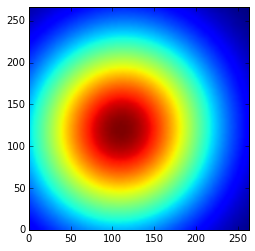

In [287]:
GraphHeatMapIpythonNotebook(GaussianWeightFunction0, xmin, xmax, ymin, ymax)

XYCoordinate [[   0.            0.        ]
 [   0.            2.6969697 ]
 [   0.            5.39393939]
 ..., 
 [ 263.          261.60606061]
 [ 263.          264.3030303 ]
 [ 263.          267.        ]]
MeanValue [ 37.4241315   22.44907513]
CovarianceMatrix [[ 55.32725957  19.00324807]
 [ 19.00324807  47.52626438]]


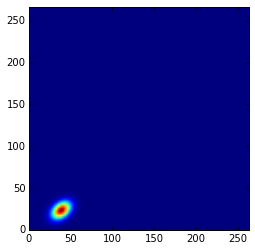

In [288]:
GraphHeatMapIpythonNotebook(GaussianWeightFunction1, xmin, xmax, ymin, ymax)

XYCoordinate [[   0.            0.        ]
 [   0.            2.6969697 ]
 [   0.            5.39393939]
 ..., 
 [ 263.          261.60606061]
 [ 263.          264.3030303 ]
 [ 263.          267.        ]]
MeanValue [ 144.74723262  125.75019614]
CovarianceMatrix [[  54.91206828   53.11421082]
 [  53.11421082  157.01002277]]


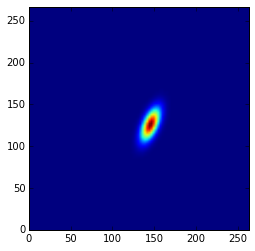

In [289]:
GraphHeatMapIpythonNotebook(GaussianWeightFunction5, xmin, xmax, ymin, ymax)

XYCoordinate [[   0.            0.        ]
 [   0.            2.6969697 ]
 [   0.            5.39393939]
 ..., 
 [ 263.          261.60606061]
 [ 263.          264.3030303 ]
 [ 263.          267.        ]]
MeanValue [  86.23613321  183.30163715]
CovarianceMatrix [[ 18.46353351  12.19659518]
 [ 12.19659518  63.28511041]]


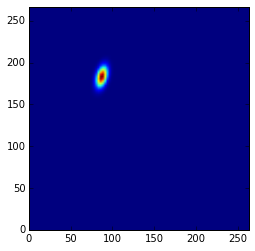

In [290]:
GraphHeatMapIpythonNotebook(GaussianWeightFunction11, xmin, xmax, ymin, ymax)

In [294]:
def WeightedZeroMoment(Image, WeightFunction):
    
    
    

SyntaxError: unexpected EOF while parsing (<ipython-input-294-ba4b38c91743>, line 1)

In [295]:
def WeightedFirstMoments(Image, WeightFunction ):
    

IndentationError: expected an indented block (<ipython-input-295-79982690dd35>, line 2)